## Bayesian Polynomial Regression

In [1]:
import numpy as np 
import arviz as az
import matplotlib.pyplot as plt 
import requests
import io 
import csv 
import pandas as pd

In [142]:
target_url = 'https://raw.githubusercontent.com/cfteach/brds/main/datasets/anscombe.csv' 

download = requests.get(target_url).content
ans = pd.read_csv(io.StringIO(download.decode('utf-8')))

x = ans[ans.group == 'II']['x'].values
y = ans[ans.group == 'II']['y'].values
x = x - x.mean()

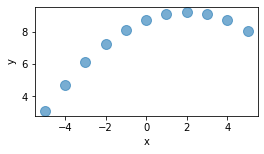

In [40]:
f=plt.figure()
f.set_figwidth(4)
f.set_figheight(2)
plt.xlabel('x')
plt.ylabel('y')
plt.plot(x,y,'C0.',alpha=0.6, markersize=20)

In [4]:
!pip install pymc3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 872 kB 27.9 MB/s 
     |████████████████████████████████| 1.8 MB 56.3 MB/s 
  Created wheel for theano-pymc: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=8e975d8835e4b3ae2df952efea023055bb2701e2ce2fdc4a280f9fdc982f5496
  Stored in directory: /root/.cache/pip/wheels/f3/af/8c/5dd7553522d74c52a7813806fc7ee1a9caa20a3f7c8fd850d5
Successfully built theano-pymc


In [5]:
import pymc3 as pm

In [42]:
with pm.Model() as model_poly:
  alpha = pm.Normal('alpha',mu=y.mean(),sigma=1) 
  beta1 = pm.Normal('beta1',mu=0.,sigma=1) 
  beta2 = pm.Normal('beta2',mu=0.,sigma=1) 
  epsilon = pm.HalfCauchy('epsilon', 5)

  mu = alpha + beta1*x + beta2*x*x + epsilon

  y_pred = pm.Normal('y_pred', mu=mu, sigma = epsilon, observed = y)

  trace_poly = pm.sample(2000, tune = 2000, return_inferencedata=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f453bf52190>,
      dtype=object)

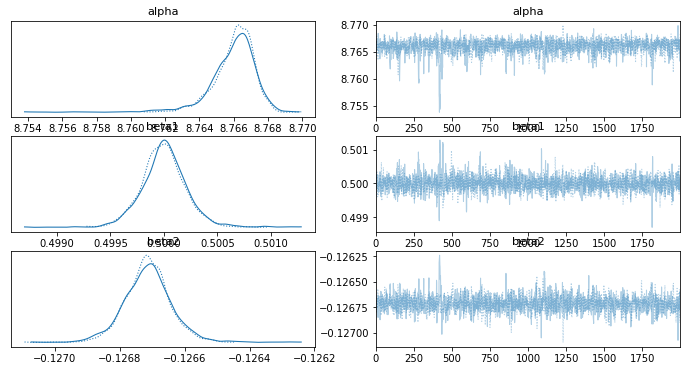

In [43]:
az.plot_trace(trace_poly, var_names = ['alpha','beta1','beta2'])

In [44]:
res = az.summary(trace_poly)
print(res)

          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha    8.766  0.001   8.764    8.768        0.0      0.0    1226.0   
beta1    0.500  0.000   0.500    0.500        0.0      0.0    2442.0   
beta2   -0.127  0.000  -0.127   -0.127        0.0      0.0    1584.0   
epsilon  0.002  0.001   0.001    0.003        0.0      0.0    1007.0   

         ess_tail  r_hat  
alpha       896.0    1.0  
beta1      1898.0    1.0  
beta2      1472.0    1.0  
epsilon    1061.0    1.0  


In [45]:
tr_alpha = res.loc['alpha']
tr_beta1 = res.loc['beta1']
tr_beta2 = res.loc['beta2']

In [46]:
print(tr_alpha)

mean            8.766
sd              0.001
hdi_3%          8.764
hdi_97%         8.768
mcse_mean       0.000
mcse_sd         0.000
ess_bulk     1226.000
ess_tail      896.000
r_hat           1.000
Name: alpha, dtype: float64


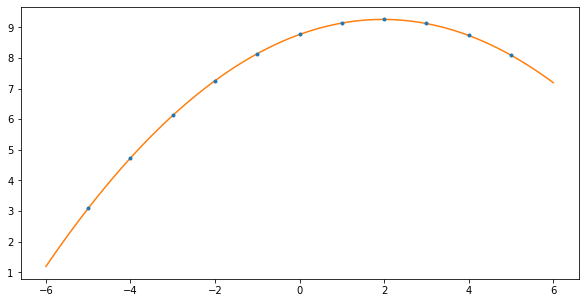

In [48]:
alpha_m = tr_alpha['mean']
beta1_m = tr_beta1['mean']
beta2_m = tr_beta2['mean']

xr = np.linspace(-6,6,100)
yr = alpha_m + beta1_m*xr + beta2_m*xr**2

f = plt.figure(figsize=(10,5))
plt.plot(xr,yr, c='C1')
plt.plot(x,y, 'C0.')

## Overfitting Problem

Let's modify the previous dataset by introducing some noise

[9.14 8.14 8.74 8.77 9.26 8.1  6.13 3.1  9.13 7.26 4.74]
5
9.14
<class 'numpy.ndarray'>


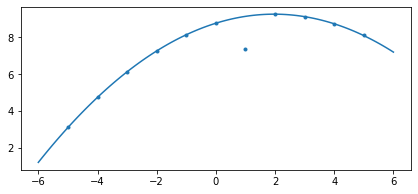

In [147]:

print(y)
tidx = int(np.floor(len(y)/2))
print(tidx)

print(y[0])
print(type(y))

yn = y.copy() 
tidx = 0
yn[tidx] = yn[tidx] + np.random.normal(0,2.)

f = plt.figure(figsize=(7,3))
plt.plot(x,yn,'C0.')
plt.plot(xr,yr)

In [149]:
with pm.Model() as poly_eps:
  alpha = pm.Normal('alpha',mu=yn.mean(),sigma=2)
  beta1 = pm.Normal('beta1',mu=0.,sigma=2) 
  beta2 = pm.Normal('beta2',mu=0.,sigma=2) 
  beta3 = pm.Normal('beta3',mu=0.,sigma=2)
  beta4 = pm.Normal('beta4',mu=0.,sigma=2) 
  beta5 = pm.Normal('beta5',mu=0.,sigma=2) 
  epsilon = pm.HalfCauchy('epsilon', 5) 

  mu = alpha + beta1 * x + beta2 * x**2 + beta3 * x**3 + beta4 * x**4 + beta5 * x**5

  yn_pred = pm.Normal('yn_pred', mu=mu, sigma = epsilon, observed = yn) 

  trace_poly_eps = pm.sample(2000, tune=3000, return_inferencedata = True)

ERROR:pymc3:There were 567 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 1353 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f452f254610>,
      dtype=object)

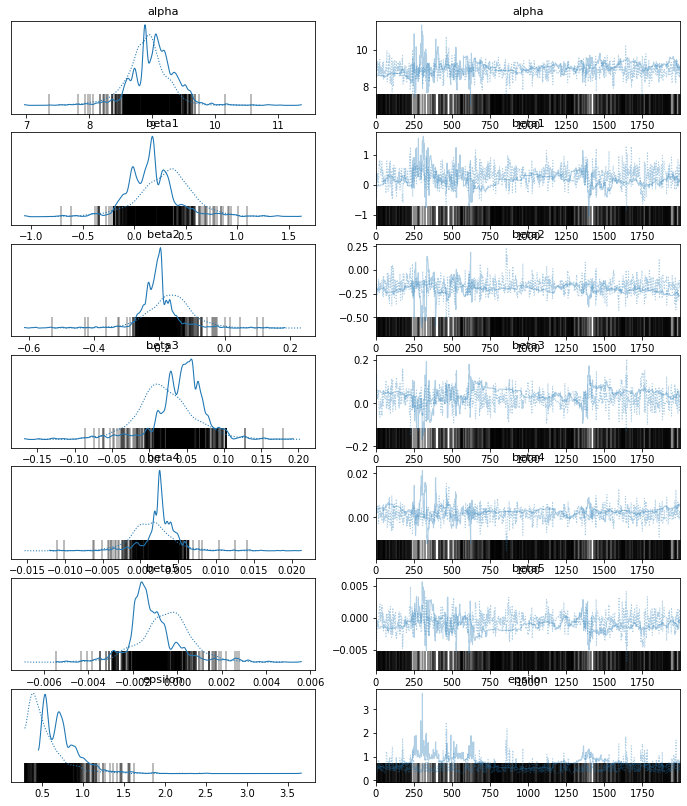

In [100]:
az.plot_trace(trace_poly_eps)

In [101]:
res2 = az.summary(trace_poly_eps)
print(res2)

          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha    8.964  0.354   8.343    9.633      0.067    0.048      20.0   
beta1    0.239  0.276  -0.232    0.807      0.032    0.023      58.0   
beta2   -0.186  0.073  -0.303   -0.035      0.005    0.004      28.0   
beta3    0.031  0.039  -0.045    0.103      0.005    0.004      43.0   
beta4    0.002  0.003  -0.004    0.006      0.000    0.000      31.0   
beta5   -0.001  0.001  -0.003    0.002      0.000    0.000      45.0   
epsilon  0.647  0.264   0.292    1.085      0.069    0.050       9.0   

         ess_tail  r_hat  
alpha       309.0   1.09  
beta1       356.0   1.05  
beta2       384.0   1.07  
beta3       179.0   1.06  
beta4       319.0   1.06  
beta5       152.0   1.05  
epsilon      82.0   1.20  


In [102]:
oalpha_m = res2.loc['alpha']['mean']
obeta1_m = res2.loc['beta1']['mean']
obeta2_m = res2.loc['beta2']['mean']
obeta3_m = res2.loc['beta3']['mean']
obeta4_m = res2.loc['beta4']['mean']
obeta5_m = res2.loc['beta5']['mean']


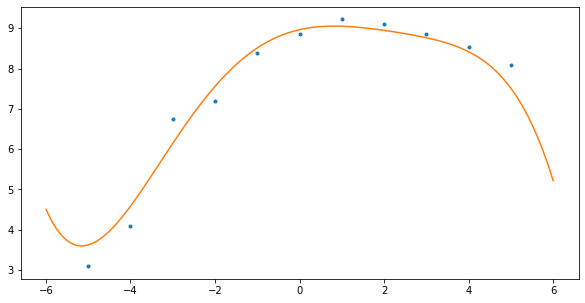

In [103]:
oyr = oalpha_m + obeta1_m*xr + obeta2_m*xr**2 + obeta3_m*xr**3 + obeta4_m*xr**4 + obeta5_m*xr**5

f = plt.figure(figsize=(10,5))
plt.plot(xr,oyr, c='C1')
plt.plot(x,yn, 'C0.')